https://drive.google.com/drive/u/0/folders/1X_ag69ToGRCF32K2a099pgvvNMg0j8nq

In [138]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

date_format="%d/%m/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
# dat = pd.read_csv("/home/ciaran/knn_Q_DAM_1-12.csv")
# dat = pd.read_csv("/home/ciaran/lasso_Q_DAM_1-12.csv")
# dat = pd.read_csv("/home/ciaran/lgbm_Q_DAM_1-12.csv")
dat = pd.read_csv("/home/ciaran/rf_Q_DAM_1-12.csv")
# dat = pd.read_csv("/home/ciaran/SH_Q_DAM_1-12.csv")
# dat = pd.read_csv("/home/ciaran/MH_Q_DAM_1-12.csv")

dat1=pd.DataFrame(dat)

column_names = ['EURPrices+{}_Forecast_10'.format(i) for i in range(0, 24)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_30'.format(i) for i in range(0, 24)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_50'.format(i) for i in range(0, 24)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_70'.format(i) for i in range(0, 24)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}_Forecast_90'.format(i) for i in range(0, 24)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['EURPrices+{}'.format(i) for i in range(0, 24)]
Y_r=dat1[column_names].dropna().stack().reset_index()
Y_r=Y_r.iloc[:,:]

Y_r["Price"]=Y_r.iloc[:,2:3]
Q_10["Price"]=Q_10.iloc[:,2:3]
Q_30["Price"]=Q_30.iloc[:,2:3]
Q_50["Price"]=Q_50.iloc[:,2:3]
Q_70["Price"]=Q_70.iloc[:,2:3]
Q_90["Price"]=Q_90.iloc[:,2:3]

In [139]:
def run_electricity_strategy(df, Q_A_Preds, Q_B_Preds,  eff_1, eff_2, capacity,charge_level, ramp_rate, min_charge_level):
    prices = []
    charge_level = charge_level    
    level_0_values = df['level_0'].unique()

    for level_0 in level_0_values:
        current_df = df[df['level_0'] == level_0]
        current_Q_A = Q_A_Preds[Q_A_Preds['level_0'] == level_0]
        current_Q_B = Q_B_Preds[Q_B_Preds['level_0'] == level_0]
        
        max_price_index = current_Q_A['Price'].idxmax()
        min_price_index = current_Q_B['Price'].idxmin()

        smaller_index = min(min_price_index, max_price_index)
        larger_index = max(min_price_index, max_price_index)
        
        remaining_prices_0 = current_df[(current_df.index > smaller_index) & (current_df.index < larger_index)]
        remaining_prices_0_A = Q_A_Preds[(Q_A_Preds.index > smaller_index) & (Q_A_Preds.index < larger_index)]
        remaining_prices_0_B = Q_B_Preds[(Q_B_Preds.index > smaller_index) & (Q_B_Preds.index < larger_index)]
        remaining_prices_1 = current_df[(current_df.index > smaller_index) & (current_df.index > larger_index)]
        remaining_prices_1_A = Q_A_Preds[(Q_A_Preds.index > smaller_index) & (Q_A_Preds.index > larger_index)]
        remaining_prices_1_B = Q_B_Preds[(Q_B_Preds.index > smaller_index) & (Q_B_Preds.index > larger_index)]
        remaining_prices_2 = current_df[(current_df.index < smaller_index) & (current_df.index < larger_index)]
        remaining_prices_2_A = Q_A_Preds[(Q_A_Preds.index < smaller_index) & (Q_A_Preds.index < larger_index)]
        remaining_prices_2_B = Q_B_Preds[(Q_B_Preds.index < smaller_index) & (Q_B_Preds.index < larger_index)]

        if current_Q_B.loc[min_price_index, 'Price'] < current_Q_A.loc[max_price_index, 'Price']:
            if min_price_index < max_price_index:
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
            
                profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index, 'Price'] * bottleneck_1)/eff_2)
            
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'], max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
            elif min_price_index > max_price_index:
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
            
                profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index, 'Price'] * bottleneck_1)/eff_2)
            
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'],  max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
            else:
                continue
                                    
      
    
        if len(remaining_prices_0) > 1:
            max_price_index_1 = remaining_prices_0_A['Price'].idxmax()
            min_price_index_1 = remaining_prices_0_B['Price'].idxmin()
            charge_level=charge_level
            if current_Q_B.loc[min_price_index_1, 'Price'] < current_Q_A.loc[max_price_index_1, 'Price']:
                  if min_price_index_1 < max_price_index_1:
                    bottleneck_1 = min(capacity - charge_level, ramp_rate)
                    charge_level += bottleneck_1
                    bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                    charge_level -= bottleneck_2
            
                    profit = (current_df.loc[max_price_index_1, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)/eff_2)
            
                    prices.append((min_price_index_1, current_df.loc[min_price_index_1, 'Price'], max_price_index_1, current_df.loc[max_price_index_1, 'Price'], profit, charge_level))
            
                  elif min_price_index_1 > max_price_index_1:
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
            
                        profit = (current_df.loc[max_price_index_1, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)/eff_2)
            
                        prices.append((min_price_index_1, current_df.loc[min_price_index_1, 'Price'], max_price_index_1, current_df.loc[max_price_index_1, 'Price'], profit, charge_level))
            
                  else:
                        continue  
 
                    
            smaller_index_1 = min(min_price_index_1, max_price_index_1)
            larger_index_1 = max(min_price_index_1, max_price_index_1)
            remaining_prices_01 = current_df[(current_df.index > smaller_index_1) & (current_df.index < larger_index_1)]
            remaining_prices_01_A = Q_A_Preds[(Q_A_Preds.index > smaller_index_1) & (Q_A_Preds.index < larger_index_1)]
            remaining_prices_01_B = Q_B_Preds[(Q_B_Preds.index > smaller_index_1) & (Q_B_Preds.index < larger_index_1)]

            if len(remaining_prices_01) > 1:
                max_price_index_4 = remaining_prices_01_A['Price'].idxmax()
                min_price_index_4 = remaining_prices_01_B['Price'].idxmin()
                if current_Q_B.loc[min_price_index_4, 'Price'] < current_Q_A.loc[max_price_index_4, 'Price']:
                    if min_price_index_4 < max_price_index_4:
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                    
                        profit = (current_df.loc[max_price_index_4, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_4, 'Price'] * bottleneck_1)/eff_2)
                    
                        prices.append((min_price_index_4, current_df.loc[min_price_index_4, 'Price'], max_price_index_1, current_df.loc[max_price_index_4, 'Price'], profit, charge_level))
                    
                    elif min_price_index_4 > max_price_index_4:
                          bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                          charge_level -= bottleneck_2
                          bottleneck_1 = min(capacity - charge_level, ramp_rate)
                          charge_level += bottleneck_1
                    
                          profit = (current_df.loc[max_price_index_4, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)/eff_2)
                    
                          prices.append((min_price_index_4, current_df.loc[min_price_index_4, 'Price'], max_price_index_4, current_df.loc[max_price_index_4, 'Price'], profit, charge_level))
                                
                    else:
                         continue

                  
                    
        if len(remaining_prices_1) > 1:
            try:

                max_price_index_2 = remaining_prices_1_A['Price'].idxmax()
                min_price_index_2 = remaining_prices_1_B['Price'].idxmin()
                if current_Q_B.loc[min_price_index_2, 'Price'] < current_Q_A.loc[max_price_index_2, 'Price']:
                      if min_price_index_2 < max_price_index_2:
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
            
                        profit = (current_df.loc[max_price_index_2, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_2, 'Price'] * bottleneck_1)/eff_2)
            
                        prices.append((min_price_index_2, current_df.loc[min_price_index_2, 'Price'], max_price_index_2, current_df.loc[max_price_index_2, 'Price'], profit, charge_level))
            
                      elif min_price_index_2 > max_price_index_2:
                         bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                         charge_level -= bottleneck_2
                         bottleneck_1 = min(capacity - charge_level, ramp_rate)
                         charge_level += bottleneck_1
            
                         profit = (current_df.loc[max_price_index_2, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_2, 'Price'] * bottleneck_1)/eff_2)
            
                         prices.append((min_price_index_2, current_df.loc[min_price_index_2, 'Price'], max_price_index_2, current_df.loc[max_price_index_2, 'Price'], profit, charge_level))
            
                      else:
                            continue
            except KeyError:
                continue
                                            
                     

    return pd.DataFrame(prices, columns=['minPriceIndex', 'minPrice','maxPriceIndex', 'maxPrice', 'profit', 'charge Level'])



r_dam_50_50=run_electricity_strategy(df=Y_r, Q_A_Preds=Q_50, Q_B_Preds=Q_50, eff_1=1, eff_2=1, capacity=4,charge_level=1, ramp_rate=1, min_charge_level=0)
r_dam_10_90=run_electricity_strategy(df=Y_r, Q_A_Preds=Q_10, Q_B_Preds=Q_90, eff_1=1, eff_2=1, capacity=4,charge_level=1, ramp_rate=1, min_charge_level=0)
r_dam_30_70=run_electricity_strategy(df=Y_r, Q_A_Preds=Q_30, Q_B_Preds=Q_70, eff_1=1, eff_2=1, capacity=4,charge_level=1, ramp_rate=1, min_charge_level=0)

In [140]:
print(sum(r_dam_50_50.iloc[:,4:5].values))
r_dam_50_50

[54239.35]


,minPriceIndex,minPrice,maxPriceIndex,maxPrice,profit,charge Level
0,5,12.26,17,31.66,19.40,1
1,14,15.16,10,25.67,10.51,1
2,13,13.92,11,23.83,8.67,1
3,28,12.89,42,36.00,23.11,1
4,29,21.41,41,39.82,18.41,1
...,...,...,...,...,...,...
1079,8715,77.62,8721,128.52,50.90,1
1080,8716,77.62,8718,88.28,10.66,1
1081,8740,81.63,8744,121.10,39.47,1
1082,8741,86.57,8743,108.00,21.43,1


In [141]:
print(sum(r_dam_10_90.iloc[:,4:5].values))
r_dam_10_90

[45956.31]


,minPriceIndex,minPrice,maxPriceIndex,maxPrice,profit,charge Level
0,25,12.64,42,36.00,23.36,1
1,26,12.88,41,39.82,26.94,1
2,27,10.26,41,20.66,10.40,1
3,50,16.23,66,37.30,21.07,1
4,52,21.21,65,37.16,15.95,1
...,...,...,...,...,...,...
809,8691,85.31,8696,252.37,167.06,1
810,8692,87.65,8695,258.87,171.22,1
811,8715,77.62,8731,117.03,39.41,1
812,8737,89.67,8744,121.10,31.43,1


In [142]:
print(sum(r_dam_30_70.iloc[:,4:5].values))
r_dam_30_70

[53247.31]


,minPriceIndex,minPrice,maxPriceIndex,maxPrice,profit,charge Level
0,4,11.58,18,28.66,17.08,1
1,14,15.16,17,31.66,16.50,1
2,15,24.69,17,31.66,6.97,1
3,25,12.64,42,36.00,23.36,1
4,26,12.88,41,39.82,26.94,1
...,...,...,...,...,...,...
1050,8716,77.62,8730,123.22,45.60,1
1051,8726,83.86,8730,121.35,37.49,1
1052,8740,81.63,8744,121.10,39.47,1
1053,8741,86.57,8743,108.00,21.43,1


In [143]:
date_format="%m/%d/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/rf_Q_1-12.csv")
dat1=pd.DataFrame(dat1)
column_names = ['lag_{}y_Forecast_10'.format(i) for i in range(2, 18)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_30'.format(i) for i in range(2, 18)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_50'.format(i) for i in range(2, 18)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_70'.format(i) for i in range(2, 18)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_90'.format(i) for i in range(2, 18)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y'.format(i) for i in range(2, 18)]
Y_r=dat1[column_names].dropna().stack().reset_index()
# YY_test= Y_r.iloc[:, 2:]
Y_r["Price"]=Y_r.iloc[:,2:3]
Q_10["Price"]=Q_10.iloc[:,2:3]
Q_30["Price"]=Q_30.iloc[:,2:3]
Q_50["Price"]=Q_50.iloc[:,2:3]
Q_70["Price"]=Q_70.iloc[:,2:3]
Q_90["Price"]=Q_90.iloc[:,2:3]

In [144]:
def run_electricity_strategy(df, Q_A_Preds, Q_B_Preds,  eff_1, eff_2, capacity,charge_level, ramp_rate, min_charge_level):
    prices = []
    charge_level = charge_level    
    level_0_values = df['level_0'].unique()

    for level_0 in level_0_values:
        current_df = df[df['level_0'] == level_0]
        current_Q_A = Q_A_Preds[Q_A_Preds['level_0'] == level_0]
        current_Q_B = Q_B_Preds[Q_B_Preds['level_0'] == level_0]
        
        max_price_index = current_Q_A['Price'].idxmax()
        min_price_index = current_Q_B['Price'].idxmin()

        smaller_index = min(min_price_index, max_price_index)
        larger_index = max(min_price_index, max_price_index)
        
        remaining_prices_0 = current_df[(current_df.index > smaller_index) & (current_df.index < larger_index)]
        remaining_prices_0_A = Q_A_Preds[(Q_A_Preds.index > smaller_index) & (Q_A_Preds.index < larger_index)]
        remaining_prices_0_B = Q_B_Preds[(Q_B_Preds.index > smaller_index) & (Q_B_Preds.index < larger_index)]
        remaining_prices_1 = current_df[(current_df.index > smaller_index) & (current_df.index > larger_index)]
        remaining_prices_1_A = Q_A_Preds[(Q_A_Preds.index > smaller_index) & (Q_A_Preds.index > larger_index)]
        remaining_prices_1_B = Q_B_Preds[(Q_B_Preds.index > smaller_index) & (Q_B_Preds.index > larger_index)]
        remaining_prices_2 = current_df[(current_df.index < smaller_index) & (current_df.index < larger_index)]
        remaining_prices_2_A = Q_A_Preds[(Q_A_Preds.index < smaller_index) & (Q_A_Preds.index < larger_index)]
        remaining_prices_2_B = Q_B_Preds[(Q_B_Preds.index < smaller_index) & (Q_B_Preds.index < larger_index)]

        if current_Q_B.loc[min_price_index, 'Price'] < current_Q_A.loc[max_price_index, 'Price']:
            if min_price_index < max_price_index:
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
            
                profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index, 'Price'] * bottleneck_1)/eff_2)
            
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'], max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
            elif min_price_index > max_price_index:
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
            
                profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index, 'Price'] * bottleneck_1)/eff_2)
            
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'],  max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
            else:
                continue
                                    
      
    
        if len(remaining_prices_0) > 1:
            max_price_index_1 = remaining_prices_0_A['Price'].idxmax()
            min_price_index_1 = remaining_prices_0_B['Price'].idxmin()
            charge_level=charge_level
            if current_Q_B.loc[min_price_index_1, 'Price'] < current_Q_A.loc[max_price_index_1, 'Price']:
                  if min_price_index_1 < max_price_index_1:
                    bottleneck_1 = min(capacity - charge_level, ramp_rate)
                    charge_level += bottleneck_1
                    bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                    charge_level -= bottleneck_2
            
                    profit = (current_df.loc[max_price_index_1, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)/eff_2)
            
                    prices.append((min_price_index_1, current_df.loc[min_price_index_1, 'Price'], max_price_index_1, current_df.loc[max_price_index_1, 'Price'], profit, charge_level))
            
                  elif min_price_index_1 > max_price_index_1:
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
            
                        profit = (current_df.loc[max_price_index_1, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)/eff_2)
            
                        prices.append((min_price_index_1, current_df.loc[min_price_index_1, 'Price'], max_price_index_1, current_df.loc[max_price_index_1, 'Price'], profit, charge_level))
            
                  else:
                        continue  
 
                    
            smaller_index_1 = min(min_price_index_1, max_price_index_1)
            larger_index_1 = max(min_price_index_1, max_price_index_1)
            remaining_prices_01 = current_df[(current_df.index > smaller_index_1) & (current_df.index < larger_index_1)]
            remaining_prices_01_A = Q_A_Preds[(Q_A_Preds.index > smaller_index_1) & (Q_A_Preds.index < larger_index_1)]
            remaining_prices_01_B = Q_B_Preds[(Q_B_Preds.index > smaller_index_1) & (Q_B_Preds.index < larger_index_1)]

            if len(remaining_prices_01) > 1:
                max_price_index_4 = remaining_prices_01_A['Price'].idxmax()
                min_price_index_4 = remaining_prices_01_B['Price'].idxmin()
                if current_Q_B.loc[min_price_index_4, 'Price'] < current_Q_A.loc[max_price_index_4, 'Price']:
                    if min_price_index_4 < max_price_index_4:
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                    
                        profit = (current_df.loc[max_price_index_4, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_4, 'Price'] * bottleneck_1)/eff_2)
                    
                        prices.append((min_price_index_4, current_df.loc[min_price_index_4, 'Price'], max_price_index_1, current_df.loc[max_price_index_4, 'Price'], profit, charge_level))
                    
                    elif min_price_index_4 > max_price_index_4:
                          bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                          charge_level -= bottleneck_2
                          bottleneck_1 = min(capacity - charge_level, ramp_rate)
                          charge_level += bottleneck_1
                    
                          profit = (current_df.loc[max_price_index_4, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)/eff_2)
                    
                          prices.append((min_price_index_4, current_df.loc[min_price_index_4, 'Price'], max_price_index_4, current_df.loc[max_price_index_4, 'Price'], profit, charge_level))
                                
                    else:
                         continue

                  
                    
        if len(remaining_prices_1) > 1:
            try:

                max_price_index_2 = remaining_prices_1_A['Price'].idxmax()
                min_price_index_2 = remaining_prices_1_B['Price'].idxmin()
                if current_Q_B.loc[min_price_index_2, 'Price'] < current_Q_A.loc[max_price_index_2, 'Price']:
                      if min_price_index_2 < max_price_index_2:
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
            
                        profit = (current_df.loc[max_price_index_2, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_2, 'Price'] * bottleneck_1)/eff_2)
            
                        prices.append((min_price_index_2, current_df.loc[min_price_index_2, 'Price'], max_price_index_2, current_df.loc[max_price_index_2, 'Price'], profit, charge_level))
            
                      elif min_price_index_2 > max_price_index_2:
                         bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                         charge_level -= bottleneck_2
                         bottleneck_1 = min(capacity - charge_level, ramp_rate)
                         charge_level += bottleneck_1
            
                         profit = (current_df.loc[max_price_index_2, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_2, 'Price'] * bottleneck_1)/eff_2)
            
                         prices.append((min_price_index_2, current_df.loc[min_price_index_2, 'Price'], max_price_index_2, current_df.loc[max_price_index_2, 'Price'], profit, charge_level))
            
                      else:
                            continue
            except KeyError:
                continue
                                            
                     

    return pd.DataFrame(prices, columns=['minPriceIndex', 'minPrice','maxPriceIndex', 'maxPrice', 'profit', 'charge Level'])


r_bm_50_50=run_electricity_strategy(df=Y_r, Q_A_Preds=Q_50, Q_B_Preds=Q_50, eff_1=1, eff_2=1, capacity=4,charge_level=1, ramp_rate=1, min_charge_level=0)
r_bm_10_90=run_electricity_strategy(df=Y_r, Q_A_Preds=Q_10, Q_B_Preds=Q_90, eff_1=1, eff_2=1, capacity=4,charge_level=1, ramp_rate=1, min_charge_level=0)
r_bm_30_70=run_electricity_strategy(df=Y_r, Q_A_Preds=Q_30, Q_B_Preds=Q_70, eff_1=1, eff_2=1, capacity=4,charge_level=1, ramp_rate=1, min_charge_level=0)

In [145]:
print(sum(r_bm_50_50.iloc[:,4:5].values))
r_bm_50_50

[96290.02]


,minPriceIndex,minPrice,maxPriceIndex,maxPrice,profit,charge Level
0,13,33.28,0,187.63,154.35,1
1,11,16.99,5,100.34,83.35,1
2,9,175.37,7,46.23,29.24,1
3,31,14.21,22,45.66,31.45,1
4,30,14.47,25,44.76,30.29,1
...,...,...,...,...,...,...
3106,17489,54.08,17493,64.43,10.35,1
3107,17490,52.97,17493,62.78,9.81,1
3108,17504,42.38,17519,257.23,214.85,1
3109,17505,38.58,17518,93.18,54.60,1


In [146]:
print(sum(r_bm_10_90.iloc[:,4:5].values))
r_bm_10_90

[168.79]


,minPriceIndex,minPrice,maxPriceIndex,maxPrice,profit,charge Level
0,10634,211.54,10624,380.33,168.79,1


In [147]:
print(sum(r_bm_30_70.iloc[:,4:5].values))
r_bm_30_70

[28664.86]


,minPriceIndex,minPrice,maxPriceIndex,maxPrice,profit,charge Level
0,925,0.00,912,7.48,7.48,1
1,924,0.00,913,6.34,6.34,1
2,1277,5.86,1269,2.01,-3.85,1
3,1337,0.00,1343,0.29,0.29,1
4,1344,13.76,1359,32.01,18.25,1
...,...,...,...,...,...,...
311,17262,83.43,17250,159.56,76.13,1
312,17312,74.89,17327,171.28,96.39,1
313,17359,68.06,17345,187.11,119.05,1
314,17504,42.38,17519,257.23,214.85,1


In [31]:
def run_electricity_strategy(df, Q_A_Preds, Q_B_Preds,  eff_1, eff_2, capacity,charge_level, ramp_rate, min_charge_level):
    prices = []
    charge_level = charge_level    
    level_0_values = df['level_0'].unique()

    for level_0 in level_0_values:
        current_df = df[df['level_0'] == level_0]
        current_Q_A = Q_A_Preds[Q_A_Preds['level_0'] == level_0]
        current_Q_B = Q_B_Preds[Q_B_Preds['level_0'] == level_0]
        
        max_price_index = current_Q_A['Price'].idxmax()
        min_price_index = current_Q_B['Price'].idxmin()

        smaller_index = min(min_price_index, max_price_index)
        larger_index = max(min_price_index, max_price_index)
        
        remaining_prices_0 = current_df[(current_df.index > smaller_index) & (current_df.index < larger_index)]
        remaining_prices_0_A = Q_A_Preds[(Q_A_Preds.index > smaller_index) & (Q_A_Preds.index < larger_index)]
        remaining_prices_0_B = Q_B_Preds[(Q_B_Preds.index > smaller_index) & (Q_B_Preds.index < larger_index)]
        remaining_prices_1 = current_df[(current_df.index > smaller_index) & (current_df.index > larger_index)]
        remaining_prices_1_A = Q_A_Preds[(Q_A_Preds.index > smaller_index) & (Q_A_Preds.index > larger_index)]
        remaining_prices_1_B = Q_B_Preds[(Q_B_Preds.index > smaller_index) & (Q_B_Preds.index > larger_index)]
        remaining_prices_2 = current_df[(current_df.index < smaller_index) & (current_df.index < larger_index)]
        remaining_prices_2_A = Q_A_Preds[(Q_A_Preds.index < smaller_index) & (Q_A_Preds.index < larger_index)]
        remaining_prices_2_B = Q_B_Preds[(Q_B_Preds.index < smaller_index) & (Q_B_Preds.index < larger_index)]

        if current_Q_B.loc[min_price_index, 'Price'] < current_Q_A.loc[max_price_index, 'Price']:
            if min_price_index < max_price_index:
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
            
                profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index, 'Price'] * bottleneck_1)/eff_2)
            
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'], max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
            elif min_price_index > max_price_index:
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
            
                profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index, 'Price'] * bottleneck_1)/eff_2)
            
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'],  max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
            else:
                continue
                                    
      
    
        if len(remaining_prices_0) > 1:
            max_price_index_1 = remaining_prices_0_A['Price'].idxmax()
            min_price_index_1 = remaining_prices_0_B['Price'].idxmin()
            charge_level=charge_level
            if current_Q_B.loc[min_price_index_1, 'Price'] < current_Q_A.loc[max_price_index_1, 'Price']:
                  if min_price_index_1 < max_price_index_1:
                    bottleneck_1 = min(capacity - charge_level, ramp_rate)
                    charge_level += bottleneck_1
                    bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                    charge_level -= bottleneck_2
            
                    profit = (current_df.loc[max_price_index_1, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)/eff_2)
            
                    prices.append((min_price_index_1, current_df.loc[min_price_index_1, 'Price'], max_price_index_1, current_df.loc[max_price_index_1, 'Price'], profit, charge_level))
            
                  elif min_price_index_1 > max_price_index_1:
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
            
                        profit = (current_df.loc[max_price_index_1, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)/eff_2)
            
                        prices.append((min_price_index_1, current_df.loc[min_price_index_1, 'Price'], max_price_index_1, current_df.loc[max_price_index_1, 'Price'], profit, charge_level))
            
                  else:
                        continue  
 
                    
            smaller_index_1 = min(min_price_index_1, max_price_index_1)
            larger_index_1 = max(min_price_index_1, max_price_index_1)
            remaining_prices_01 = current_df[(current_df.index > smaller_index_1) & (current_df.index < larger_index_1)]
            remaining_prices_01_A = Q_A_Preds[(Q_A_Preds.index > smaller_index_1) & (Q_A_Preds.index < larger_index_1)]
            remaining_prices_01_B = Q_B_Preds[(Q_B_Preds.index > smaller_index_1) & (Q_B_Preds.index < larger_index_1)]

            if len(remaining_prices_01) > 1:
                max_price_index_4 = remaining_prices_01_A['Price'].idxmax()
                min_price_index_4 = remaining_prices_01_B['Price'].idxmin()
                if current_Q_B.loc[min_price_index_4, 'Price'] < current_Q_A.loc[max_price_index_4, 'Price']:
                    if min_price_index_4 < max_price_index_4:
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                    
                        profit = (current_df.loc[max_price_index_4, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_4, 'Price'] * bottleneck_1)/eff_2)
                    
                        prices.append((min_price_index_4, current_df.loc[min_price_index_4, 'Price'], max_price_index_1, current_df.loc[max_price_index_4, 'Price'], profit, charge_level))
                    
                    elif min_price_index_4 > max_price_index_4:
                          bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                          charge_level -= bottleneck_2
                          bottleneck_1 = min(capacity - charge_level, ramp_rate)
                          charge_level += bottleneck_1
                    
                          profit = (current_df.loc[max_price_index_4, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)/eff_2)
                    
                          prices.append((min_price_index_4, current_df.loc[min_price_index_4, 'Price'], max_price_index_4, current_df.loc[max_price_index_4, 'Price'], profit, charge_level))
                                
                    else:
                         continue

                  
                    
        if len(remaining_prices_1) > 1:
            max_price_index_2 = remaining_prices_1_A['Price'].idxmax()
            min_price_index_2 = remaining_prices_1_B['Price'].idxmin()
            if current_Q_B.loc[min_price_index_2, 'Price'] < current_Q_A.loc[max_price_index_2, 'Price']:
                  if min_price_index_2 < max_price_index_2:
                    bottleneck_1 = min(capacity - charge_level, ramp_rate)
                    charge_level += bottleneck_1
                    bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                    charge_level -= bottleneck_2
            
                    profit = (current_df.loc[max_price_index_2, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_2, 'Price'] * bottleneck_1)/eff_2)
            
                    prices.append((min_price_index_2, current_df.loc[min_price_index_2, 'Price'], max_price_index_2, current_df.loc[max_price_index_2, 'Price'], profit, charge_level))
            
                  elif min_price_index_2 > max_price_index_2:
                     bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                     charge_level -= bottleneck_2
                     bottleneck_1 = min(capacity - charge_level, ramp_rate)
                     charge_level += bottleneck_1
            
                     profit = (current_df.loc[max_price_index_2, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_2, 'Price'] * bottleneck_1)/eff_2)
            
                     prices.append((min_price_index_2, current_df.loc[min_price_index_2, 'Price'], max_price_index_2, current_df.loc[max_price_index_2, 'Price'], profit, charge_level))
            
                  else:
                        continue
                    

                    
                     

    return pd.DataFrame(prices, columns=['minPriceIndex', 'minPrice','maxPriceIndex', 'maxPrice', 'profit', 'charge Level'])


run_electricity_strategy(df=Y_r, Q_A_Preds=Q_10, Q_B_Preds=Q_90, eff_1=1, eff_2=1, capacity=4,charge_level=1, ramp_rate=1, min_charge_level=0)

KeyError: 120

In [5]:
print(sum(run_electricity_strategy(df=Y_r, Q_A_Preds=Q_10, Q_B_Preds=Q_90, eff_1=1, eff_2=1, capacity=4,charge_level=1, ramp_rate=1, min_charge_level=0).iloc[:,4:5].values))

[39970.74]


In [ ]:
def run_electricity_strategy(df, Q_A_Preds, Q_B_Preds,  eff_1, eff_2, capacity,charge_level, ramp_rate, min_charge_level):
    prices = []
    charge_level = charge_level    
    level_0_values = df['level_0'].unique()

    for level_0 in level_0_values:
        current_df = df[df['level_0'] == level_0]
        current_Q_A = Q_A_Preds[Q_A_Preds['level_0'] == level_0]
        current_Q_B = Q_B_Preds[Q_B_Preds['level_0'] == level_0]
        
        max_price_index = current_Q_A['Price'].idxmax()
        min_price_index = current_Q_B['Price'].idxmin()

        smaller_index = min(min_price_index, max_price_index)
        larger_index = max(min_price_index, max_price_index)
        
        remaining_prices_0 = current_df[(current_df.index > smaller_index) & (current_df.index < larger_index)]
        remaining_prices_0_A = Q_A_Preds[(Q_A_Preds.index > smaller_index) & (Q_A_Preds.index < larger_index)]
        remaining_prices_0_B = Q_B_Preds[(Q_B_Preds.index > smaller_index) & (Q_B_Preds.index < larger_index)]
        remaining_prices_1 = current_df[(current_df.index > smaller_index) & (current_df.index > larger_index)]
        remaining_prices_1_A = Q_A_Preds[(Q_A_Preds.index > smaller_index) & (Q_A_Preds.index > larger_index)]
        remaining_prices_1_B = Q_B_Preds[(Q_B_Preds.index > smaller_index) & (Q_B_Preds.index > larger_index)]
        remaining_prices_2 = current_df[(current_df.index < smaller_index) & (current_df.index < larger_index)]
        remaining_prices_2_A = Q_A_Preds[(Q_A_Preds.index < smaller_index) & (Q_A_Preds.index < larger_index)]
        remaining_prices_2_B = Q_B_Preds[(Q_B_Preds.index < smaller_index) & (Q_B_Preds.index < larger_index)]

        if current_Q_B.loc[min_price_index, 'Price'] < current_Q_A.loc[max_price_index, 'Price']:
            if min_price_index < max_price_index:
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
            
                profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index, 'Price'] * bottleneck_1)/eff_2)
            
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'], max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
            elif min_price_index > max_price_index:
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
            
                profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index, 'Price'] * bottleneck_1)/eff_2)
            
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'],  max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
            else:
                continue
                                    
      
    
        if len(remaining_prices_0) > 1:
            max_price_index_1 = remaining_prices_0_A['Price'].idxmax()
            min_price_index_1 = remaining_prices_0_B['Price'].idxmin()
            charge_level=charge_level
            if current_Q_B.loc[min_price_index_1, 'Price'] < current_Q_A.loc[max_price_index_1, 'Price']:
                  if min_price_index_1 < max_price_index_1:
                    bottleneck_1 = min(capacity - charge_level, ramp_rate)
                    charge_level += bottleneck_1
                    bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                    charge_level -= bottleneck_2
            
                    profit = (current_df.loc[max_price_index_1, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)/eff_2)
            
                    prices.append((min_price_index_1, current_df.loc[min_price_index_1, 'Price'], max_price_index_1, current_df.loc[max_price_index_1, 'Price'], profit, charge_level))
            
                  elif min_price_index_1 > max_price_index_1:
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
            
                        profit = (current_df.loc[max_price_index_1, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)/eff_2)
            
                        prices.append((min_price_index_1, current_df.loc[min_price_index_1, 'Price'], max_price_index_1, current_df.loc[max_price_index_1, 'Price'], profit, charge_level))
            
                  else:
                        continue  
 
                    
            smaller_index_1 = min(min_price_index_1, max_price_index_1)
            larger_index_1 = max(min_price_index_1, max_price_index_1)
            remaining_prices_01 = current_df[(current_df.index > smaller_index_1) & (current_df.index < larger_index_1)]
            remaining_prices_01_A = Q_A_Preds[(Q_A_Preds.index > smaller_index_1) & (Q_A_Preds.index < larger_index_1)]
            remaining_prices_01_B = Q_B_Preds[(Q_B_Preds.index > smaller_index_1) & (Q_B_Preds.index < larger_index_1)]

            if len(remaining_prices_01) > 1:
                max_price_index_4 = remaining_prices_01_A['Price'].idxmax()
                min_price_index_4 = remaining_prices_01_B['Price'].idxmin()
                if current_Q_B.loc[min_price_index_4, 'Price'] < current_Q_A.loc[max_price_index_4, 'Price']:
                    if min_price_index_4 < max_price_index_4:
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                    
                        profit = (current_df.loc[max_price_index_4, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_4, 'Price'] * bottleneck_1)/eff_2)
                    
                        prices.append((min_price_index_4, current_df.loc[min_price_index_4, 'Price'], max_price_index_1, current_df.loc[max_price_index_4, 'Price'], profit, charge_level))
                    
                    elif min_price_index_4 > max_price_index_4:
                          bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                          charge_level -= bottleneck_2
                          bottleneck_1 = min(capacity - charge_level, ramp_rate)
                          charge_level += bottleneck_1
                    
                          profit = (current_df.loc[max_price_index_4, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)/eff_2)
                    
                          prices.append((min_price_index_4, current_df.loc[min_price_index_4, 'Price'], max_price_index_4, current_df.loc[max_price_index_4, 'Price'], profit, charge_level))
                                
                    else:
                         continue

                  
                    
        if len(remaining_prices_1) > 1:
            max_price_index_2 = remaining_prices_1_A['Price'].idxmax()
            min_price_index_2 = remaining_prices_1_B['Price'].idxmin()
            if current_Q_B.loc[min_price_index_2, 'Price'] < current_Q_A.loc[max_price_index_2, 'Price']:
                  if min_price_index_2 < max_price_index_2:
                    bottleneck_1 = min(capacity - charge_level, ramp_rate)
                    charge_level += bottleneck_1
                    bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                    charge_level -= bottleneck_2
            
                    profit = (current_df.loc[max_price_index_2, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_2, 'Price'] * bottleneck_1)/eff_2)
            
                    prices.append((min_price_index_2, current_df.loc[min_price_index_2, 'Price'], max_price_index_2, current_df.loc[max_price_index_2, 'Price'], profit, charge_level))
            
                  elif min_price_index_2 > max_price_index_2:
                     bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                     charge_level -= bottleneck_2
                     bottleneck_1 = min(capacity - charge_level, ramp_rate)
                     charge_level += bottleneck_1
            
                     profit = (current_df.loc[max_price_index_2, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_2, 'Price'] * bottleneck_1)/eff_2)
            
                     prices.append((min_price_index_2, current_df.loc[min_price_index_2, 'Price'], max_price_index_2, current_df.loc[max_price_index_2, 'Price'], profit, charge_level))
            
                  else:
                        continue
                    

                    
                     

    return pd.DataFrame(prices, columns=['minPriceIndex', 'minPrice','maxPriceIndex', 'maxPrice', 'profit', 'charge Level'])


run_electricity_strategy(df=Y_r, Q_A_Preds=Q_10, Q_B_Preds=Q_90, eff_1=1, eff_2=1, capacity=4,charge_level=1, ramp_rate=1, min_charge_level=0)

In [ ]:
def run_electricity_strategy(df, Q_A_Preds, Q_B_Preds,  eff_1, eff_2, capacity,charge_level, ramp_rate, min_charge_level):
    prices = []
    charge_level = charge_level    
    level_0_values = df['level_0'].unique()

    for level_0 in level_0_values:
        current_df = df[df['level_0'] == level_0]
        current_Q_A = Q_A_Preds[Q_A_Preds['level_0'] == level_0]
        current_Q_B = Q_B_Preds[Q_B_Preds['level_0'] == level_0]
        
        max_price_index = current_Q_A['Price'].idxmax()
        min_price_index = current_Q_B['Price'].idxmin()

        smaller_index = min(min_price_index, max_price_index)
        larger_index = max(min_price_index, max_price_index)
        
        remaining_prices_0 = current_df[(current_df.index > smaller_index) & (current_df.index < larger_index)]
        remaining_prices_0_A = Q_A_Preds[(Q_A_Preds.index > smaller_index) & (Q_A_Preds.index < larger_index)]
        remaining_prices_0_B = Q_B_Preds[(Q_B_Preds.index > smaller_index) & (Q_B_Preds.index < larger_index)]
        remaining_prices_1 = current_df[(current_df.index > smaller_index) & (current_df.index > larger_index)]
        remaining_prices_1_A = Q_A_Preds[(Q_A_Preds.index > smaller_index) & (Q_A_Preds.index > larger_index)]
        remaining_prices_1_B = Q_B_Preds[(Q_B_Preds.index > smaller_index) & (Q_B_Preds.index > larger_index)]
        remaining_prices_2 = current_df[(current_df.index < smaller_index) & (current_df.index < larger_index)]
        remaining_prices_2_A = Q_A_Preds[(Q_A_Preds.index < smaller_index) & (Q_A_Preds.index < larger_index)]
        remaining_prices_2_B = Q_B_Preds[(Q_B_Preds.index < smaller_index) & (Q_B_Preds.index < larger_index)]

        if current_Q_B.loc[min_price_index, 'Price'] < current_Q_A.loc[max_price_index, 'Price']:
            if min_price_index < max_price_index:
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
            
                profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index, 'Price'] * bottleneck_1)/eff_2)
            
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'], max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
            elif min_price_index > max_price_index:
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
            
                profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index, 'Price'] * bottleneck_1)/eff_2)
            
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'],  max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
            else:
                continue
                                    
      
    
        if len(remaining_prices_0) > 1:
            max_price_index_1 = remaining_prices_0_A['Price'].idxmax()
            min_price_index_1 = remaining_prices_0_B['Price'].idxmin()
            charge_level=charge_level
            if current_Q_B.loc[min_price_index_1, 'Price'] < current_Q_A.loc[max_price_index_1, 'Price']:
                  if min_price_index_1 < max_price_index_1:
                    bottleneck_1 = min(capacity - charge_level, ramp_rate)
                    charge_level += bottleneck_1
                    bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                    charge_level -= bottleneck_2
            
                    profit = (current_df.loc[max_price_index_1, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)/eff_2)
            
                    prices.append((min_price_index_1, current_df.loc[min_price_index_1, 'Price'], max_price_index_1, current_df.loc[max_price_index_1, 'Price'], profit, charge_level))
            
                  elif min_price_index_1 > max_price_index_1:
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
            
                        profit = (current_df.loc[max_price_index_1, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)/eff_2)
            
                        prices.append((min_price_index_1, current_df.loc[min_price_index_1, 'Price'], max_price_index_1, current_df.loc[max_price_index_1, 'Price'], profit, charge_level))
            
                  else:
                        continue  
 
                    
            smaller_index_1 = min(min_price_index_1, max_price_index_1)
            larger_index_1 = max(min_price_index_1, max_price_index_1)
            remaining_prices_01 = current_df[(current_df.index > smaller_index_1) & (current_df.index < larger_index_1)]
            remaining_prices_01_A = Q_A_Preds[(Q_A_Preds.index > smaller_index_1) & (Q_A_Preds.index < larger_index_1)]
            remaining_prices_01_B = Q_B_Preds[(Q_B_Preds.index > smaller_index_1) & (Q_B_Preds.index < larger_index_1)]

            if len(remaining_prices_01) > 1:
                max_price_index_4 = remaining_prices_01_A['Price'].idxmax()
                min_price_index_4 = remaining_prices_01_B['Price'].idxmin()
                if current_Q_B.loc[min_price_index_4, 'Price'] < current_Q_A.loc[max_price_index_4, 'Price']:
                    if min_price_index_4 < max_price_index_4:
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                    
                        profit = (current_df.loc[max_price_index_4, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_4, 'Price'] * bottleneck_1)/eff_2)
                    
                        prices.append((min_price_index_4, current_df.loc[min_price_index_4, 'Price'], max_price_index_1, current_df.loc[max_price_index_4, 'Price'], profit, charge_level))
                    
                    elif min_price_index_4 > max_price_index_4:
                          bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                          charge_level -= bottleneck_2
                          bottleneck_1 = min(capacity - charge_level, ramp_rate)
                          charge_level += bottleneck_1
                    
                          profit = (current_df.loc[max_price_index_4, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)/eff_2)
                    
                          prices.append((min_price_index_4, current_df.loc[min_price_index_4, 'Price'], max_price_index_4, current_df.loc[max_price_index_4, 'Price'], profit, charge_level))
                                
                    else:
                         continue

                  
                    
        if len(remaining_prices_1) > 1:
            max_price_index_2 = remaining_prices_1_A['Price'].idxmax()
            min_price_index_2 = remaining_prices_1_B['Price'].idxmin()
            if current_Q_B.loc[min_price_index_2, 'Price'] < current_Q_A.loc[max_price_index_2, 'Price']:
                  if min_price_index_2 < max_price_index_2:
                    bottleneck_1 = min(capacity - charge_level, ramp_rate)
                    charge_level += bottleneck_1
                    bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                    charge_level -= bottleneck_2
            
                    profit = (current_df.loc[max_price_index_2, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_2, 'Price'] * bottleneck_1)/eff_2)
            
                    prices.append((min_price_index_2, current_df.loc[min_price_index_2, 'Price'], max_price_index_2, current_df.loc[max_price_index_2, 'Price'], profit, charge_level))
            
                  elif min_price_index_2 > max_price_index_2:
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
            
                        profit = (current_df.loc[max_price_index_2, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_2, 'Price'] * bottleneck_1)/eff_2)
            
                        prices.append((min_price_index_2, current_df.loc[min_price_index_2, 'Price'], max_price_index_2, current_df.loc[max_price_index_2, 'Price'], profit, charge_level))
            
                  else:
                        continue
                    

                    
                    
        if len(remaining_prices_2) > 1:
            max_price_index_3 = remaining_prices_2_A['Price'].idxmax()
            min_price_index_3 = remaining_prices_2_B['Price'].idxmin()
            if current_Q_A.loc[min_price_index_3, 'Price'] < current_Q_B.loc[max_price_index_3, 'Price']:
                  if min_price_index_3 < max_price_index_3:
                    bottleneck_1 = min(capacity - charge_level, ramp_rate)
                    charge_level += bottleneck_1
                    bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                    charge_level -= bottleneck_2
            
                    profit = (current_df.loc[max_price_index_3, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_3, 'Price'] * bottleneck_1)/eff_2)
            
                    prices.append((min_price_index_3, current_df.loc[min_price_index_3, 'Price'], max_price_index_3, current_df.loc[max_price_index_3, 'Price'], profit, charge_level))
            
                  elif min_price_index_3 > max_price_index_3:
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
            
                        profit = (current_df.loc[max_price_index_3, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index_3, 'Price'] * bottleneck_1)/eff_2)
            
                        prices.append((min_price_index_3, current_df.loc[min_price_index_3, 'Price'], max_price_index_3, current_df.loc[max_price_index_3, 'Price'], profit, charge_level))
            
                  else:
                        continue         

    return pd.DataFrame(prices, columns=['minPriceIndex', 'minPrice','maxPriceIndex', 'maxPrice', 'profit', 'charge Level'])


run_electricity_strategy(df=Y_r, Q_A_Preds=Q_10, Q_B_Preds=Q_90, eff_1=1, eff_2=1, capacity=4,charge_level=1, ramp_rate=1, min_charge_level=0)

In [23]:
def run_electricity_strategy(df, Q_A_Preds, Q_B_Preds,  eff_1, eff_2, capacity,charge_level, ramp_rate, min_charge_level):
    prices = []
    charge_level = charge_level    
    level_0_values = df['level_0'].unique()

    for level_0 in level_0_values:
        current_df  = df[df['level_0'] == level_0]
        current_Q_A = Q_A_Preds[Q_A_Preds['level_0'] == level_0]
        current_Q_B = Q_B_Preds[Q_B_Preds['level_0'] == level_0]

        max_price_index = current_Q_A['Price'].idxmax()
        min_price_index = current_Q_B['Price'].idxmin()

#         smaller_index = min(min_price_index, max_price_index)
#         larger_index = max(min_price_index, max_price_index)
        
#         remaining_prices_0 = current_df[(current_df.index > smaller_index) & (current_df.index < larger_index)]
#         remaining_prices_1 = current_df[(current_df.index > smaller_index) & (current_df.index > larger_index)]
#         remaining_prices_2 = current_df[(current_df.index < smaller_index) & (current_df.index < larger_index)]

        if current_Q_B.loc[min_price_index, 'Price'] < current_Q_A.loc[max_price_index, 'Price']:
            if min_price_index < max_price_index:
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
            
                profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index, 'Price'] * bottleneck_1)/eff_2)
            
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'], max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
            elif min_price_index > max_price_index:
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
            
                profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff_1) - ((current_df.loc[min_price_index, 'Price'] * bottleneck_1)/eff_2)
            
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'],  max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
            else:
                continue                   
   

    return pd.DataFrame(prices, columns=['minPriceIndex', 'minPrice','maxPriceIndex', 'maxPrice', 'profit', 'charge Level'])


run_electricity_strategy(df=Y_r, Q_A_Preds=Q_10, Q_B_Preds=Q_90, eff_1=1, eff_2=1, capacity=4,charge_level=1, ramp_rate=1, min_charge_level=0)

,minPriceIndex,minPrice,maxPriceIndex,maxPrice,profit,charge Level
0,25,12.64,42,36.00,23.36,1
1,50,16.23,66,37.30,21.07,1
2,85,15.00,91,33.17,18.17,1
3,119,-0.05,104,35.19,35.24,1
4,123,-1.00,132,2.12,3.12,1
...,...,...,...,...,...,...
343,8643,86.00,8659,180.29,94.29,1
344,8667,86.24,8672,246.11,159.87,1
345,8691,85.31,8696,252.37,167.06,1
346,8715,77.62,8731,117.03,39.41,1


In [25]:
print(sum(run_electricity_strategy(df=Y_r, Q_A_Preds=Q_10, Q_B_Preds=Q_90, eff_1=1, eff_2=1, capacity=4,charge_level=1, ramp_rate=1, min_charge_level=0).iloc[:,4:5].values))

[24640.38]


In [6]:
def run_electricity_strategy(df, eff, capacity,charge_level, ramp_rate, min_charge_level):
    prices = []
    charge_level = charge_level    
    level_0_values = df['level_0'].unique()

    for level_0 in level_0_values:
        current_df = df[df['level_0'] == level_0]
        max_price_index = current_df['Price'].idxmax()
        min_price_index = current_df['Price'].idxmin()

        smaller_index = min(min_price_index, max_price_index)
        larger_index = max(min_price_index, max_price_index)
        
        remaining_prices_0 = current_df[(current_df.index > smaller_index) & (current_df.index < larger_index)]
        remaining_prices_1 = current_df[(current_df.index > smaller_index) & (current_df.index > larger_index)]
        remaining_prices_2 = current_df[(current_df.index < smaller_index) & (current_df.index < larger_index)]

        if current_df.loc[min_price_index, 'Price'] < current_df.loc[max_price_index, 'Price'] * eff:
            if min_price_index < max_price_index:
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
            
                profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index, 'Price'] * bottleneck_1)
            
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'], max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
            elif min_price_index > max_price_index:
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
            
                profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index, 'Price'] * bottleneck_1)
            
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'],  max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
            else:
                continue
                                    
      
    
        if len(remaining_prices_0) > 1:
            max_price_index_1 = remaining_prices_0['Price'].idxmax()
            min_price_index_1 = remaining_prices_0['Price'].idxmin()
            charge_level=charge_level
            if current_df.loc[min_price_index_1, 'Price'] < current_df.loc[max_price_index_1, 'Price'] * eff:
                  if min_price_index_1 < max_price_index_1:
                    bottleneck_1 = min(capacity - charge_level, ramp_rate)
                    charge_level += bottleneck_1
                    bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                    charge_level -= bottleneck_2
            
                    profit = (current_df.loc[max_price_index_1, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)
            
                    prices.append((min_price_index_1, current_df.loc[min_price_index_1, 'Price'], max_price_index_1, current_df.loc[max_price_index_1, 'Price'], profit, charge_level))
            
                  elif min_price_index_1 > max_price_index_1:
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
            
                        profit = (current_df.loc[max_price_index_1, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)
            
                        prices.append((min_price_index_1, current_df.loc[min_price_index_1, 'Price'], max_price_index_1, current_df.loc[max_price_index_1, 'Price'], profit, charge_level))
            
                  else:
                        continue  
 
                    
            smaller_index_1 = min(min_price_index_1, max_price_index_1)
            larger_index_1 = max(min_price_index_1, max_price_index_1)
            remaining_prices_01 = current_df[(current_df.index > smaller_index_1) & (current_df.index < larger_index_1)]
            if len(remaining_prices_01) > 1:
                max_price_index_4 = remaining_prices_01['Price'].idxmax()
                min_price_index_4 = remaining_prices_01['Price'].idxmin()
                if current_df.loc[min_price_index_4, 'Price'] < current_df.loc[max_price_index_4, 'Price'] * eff:
                    if min_price_index_4 < max_price_index_4:
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                    
                        profit = (current_df.loc[max_price_index_4, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_4, 'Price'] * bottleneck_1)
                    
                        prices.append((min_price_index_4, current_df.loc[min_price_index_4, 'Price'], max_price_index_1, current_df.loc[max_price_index_4, 'Price'], profit, charge_level))
                    
                    elif min_price_index_4 > max_price_index_4:
                          bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                          charge_level -= bottleneck_2
                          bottleneck_1 = min(capacity - charge_level, ramp_rate)
                          charge_level += bottleneck_1
                    
                          profit = (current_df.loc[max_price_index_4, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)
                    
                          prices.append((min_price_index_4, current_df.loc[min_price_index_4, 'Price'], max_price_index_4, current_df.loc[max_price_index_4, 'Price'], profit, charge_level))
                                
                    else:
                         continue

                    
                    
        if len(remaining_prices_1) > 1:
            max_price_index_2 = remaining_prices_1['Price'].idxmax()
            min_price_index_2 = remaining_prices_1['Price'].idxmin()
            if current_df.loc[min_price_index_2, 'Price'] < current_df.loc[max_price_index_2, 'Price'] * eff:
                  if min_price_index_2 < max_price_index_2:
                    bottleneck_1 = min(capacity - charge_level, ramp_rate)
                    charge_level += bottleneck_1
                    bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                    charge_level -= bottleneck_2
            
                    profit = (current_df.loc[max_price_index_2, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_2, 'Price'] * bottleneck_1)
            
                    prices.append((min_price_index_2, current_df.loc[min_price_index_2, 'Price'], max_price_index_2, current_df.loc[max_price_index_2, 'Price'], profit, charge_level))
            
                  elif min_price_index_2 > max_price_index_2:
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
            
                        profit = (current_df.loc[max_price_index_2, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_2, 'Price'] * bottleneck_1)
            
                        prices.append((min_price_index_2, current_df.loc[min_price_index_2, 'Price'], max_price_index_2, current_df.loc[max_price_index_2, 'Price'], profit, charge_level))
            
                  else:
                        continue
                    

                    
                    
        if len(remaining_prices_2) > 1:
            max_price_index_3 = remaining_prices_2['Price'].idxmax()
            min_price_index_3 = remaining_prices_2['Price'].idxmin()
            if current_df.loc[min_price_index_3, 'Price'] < current_df.loc[max_price_index_3, 'Price'] * eff:
                  if min_price_index_3 < max_price_index_3:
                    bottleneck_1 = min(capacity - charge_level, ramp_rate)
                    charge_level += bottleneck_1
                    bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                    charge_level -= bottleneck_2
            
                    profit = (current_df.loc[max_price_index_3, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_3, 'Price'] * bottleneck_1)
            
                    prices.append((min_price_index_3, current_df.loc[min_price_index_3, 'Price'], max_price_index_3, current_df.loc[max_price_index_3, 'Price'], profit, charge_level))
            
                  elif min_price_index_3 > max_price_index_3:
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
            
                        profit = (current_df.loc[max_price_index_3, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_3, 'Price'] * bottleneck_1)
            
                        prices.append((min_price_index_3, current_df.loc[min_price_index_3, 'Price'], max_price_index_3, current_df.loc[max_price_index_3, 'Price'], profit, charge_level))
            
                  else:
                        continue         

    return pd.DataFrame(prices, columns=['minPriceIndex', 'minPrice','maxPriceIndex', 'maxPrice', 'profit', 'charge Level'])


run_electricity_strategy(df=Y_r, eff=1, capacity=1,charge_level=1, ramp_rate=1, min_charge_level=0)

,minPriceIndex,minPrice,maxPriceIndex,maxPrice,profit,charge Level
0,4,11.58,16,31.66,31.66,0
1,5,12.26,9,25.83,13.57,0
2,6,15.34,9,23.22,7.88,0
3,23,13.98,17,31.66,-13.98,1
4,3,14.12,0,24.65,10.53,1
...,...,...,...,...,...,...
1647,8713,81.21,8712,81.90,0.69,1
1648,8739,81.06,8745,148.90,148.90,0
1649,8742,81.53,8744,121.10,39.57,0
1650,8759,83.68,8746,135.88,-83.68,1


In [29]:
print(sum(run_electricity_strategy(df=Y_r, eff=1, capacity=4,charge_level=1, ramp_rate=1, min_charge_level=0).iloc[:,4:5].values))

[74321.79]


In [115]:
date_format="%m/%d/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/SH_Q_1-12.csv")
dat1=pd.DataFrame(dat1)
column_names = ['lag_{}y_Forecast_50'.format(i) for i in range(2, 18)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y'.format(i) for i in range(2, 18)]
Y_r=dat1[column_names].dropna().stack().reset_index()
# YY_test= Y_r.iloc[:, 2:]
Y_r["Price"]=Y_r.iloc[:,2:3]


In [116]:
Y_r.head(n=40)

,level_0,level_1,0,Price
0,0,lag_2y,187.63,187.63
1,0,lag_3y,140.06,140.06
2,0,lag_4y,194.62,194.62
3,0,lag_5y,40.34,40.34
4,0,lag_6y,30.91,30.91
5,0,lag_7y,100.34,100.34
6,0,lag_8y,19.44,19.44
7,0,lag_9y,46.23,46.23
8,0,lag_10y,79.54,79.54
9,0,lag_11y,175.37,175.37


In [117]:
def run_electricity_strategy(df, eff, capacity,charge_level, ramp_rate, min_charge_level):
    prices = []
    charge_level = charge_level    
    level_0_values = df['level_0'].unique()

    for level_0 in level_0_values:
        current_df = df[df['level_0'] == level_0]
        max_price_index = current_df['Price'].idxmax()
        min_price_index = current_df['Price'].idxmin()

        smaller_index = min(min_price_index, max_price_index)
        larger_index = max(min_price_index, max_price_index)
        
        remaining_prices_0 = current_df[(current_df.index > smaller_index) & (current_df.index < larger_index)]
        remaining_prices_1 = current_df[(current_df.index > smaller_index) & (current_df.index > larger_index)]
        remaining_prices_2 = current_df[(current_df.index < smaller_index) & (current_df.index < larger_index)]

        if current_df.loc[min_price_index, 'Price'] < current_df.loc[max_price_index, 'Price'] * eff:
            if min_price_index < max_price_index:
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
            
                profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index, 'Price'] * bottleneck_1)
            
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'], max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
            elif min_price_index > max_price_index:
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
            
                profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index, 'Price'] * bottleneck_1)
            
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'],  max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
            else:
                continue
                                    
      
    
        if len(remaining_prices_0) > 1:
            max_price_index_1 = remaining_prices_0['Price'].idxmax()
            min_price_index_1 = remaining_prices_0['Price'].idxmin()
            charge_level=charge_level
            if current_df.loc[min_price_index_1, 'Price'] < current_df.loc[max_price_index_1, 'Price'] * eff:
                  if min_price_index_1 < max_price_index_1:
                    bottleneck_1 = min(capacity - charge_level, ramp_rate)
                    charge_level += bottleneck_1
                    bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                    charge_level -= bottleneck_2
            
                    profit = (current_df.loc[max_price_index_1, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)
            
                    prices.append((min_price_index_1, current_df.loc[min_price_index_1, 'Price'], max_price_index_1, current_df.loc[max_price_index_1, 'Price'], profit, charge_level))
            
                  elif min_price_index_1 > max_price_index_1:
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
            
                        profit = (current_df.loc[max_price_index_1, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)
            
                        prices.append((min_price_index_1, current_df.loc[min_price_index_1, 'Price'], max_price_index_1, current_df.loc[max_price_index_1, 'Price'], profit, charge_level))
            
                  else:
                        continue  
 
                    
            smaller_index_1 = min(min_price_index_1, max_price_index_1)
            larger_index_1 = max(min_price_index_1, max_price_index_1)
            remaining_prices_01 = current_df[(current_df.index > smaller_index_1) & (current_df.index < larger_index_1)]
            if len(remaining_prices_01) > 1:
                max_price_index_4 = remaining_prices_01['Price'].idxmax()
                min_price_index_4 = remaining_prices_01['Price'].idxmin()
                if current_df.loc[min_price_index_4, 'Price'] < current_df.loc[max_price_index_4, 'Price'] * eff:
                    if min_price_index_4 < max_price_index_4:
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                    
                        profit = (current_df.loc[max_price_index_4, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_4, 'Price'] * bottleneck_1)
                    
                        prices.append((min_price_index_4, current_df.loc[min_price_index_4, 'Price'], max_price_index_1, current_df.loc[max_price_index_4, 'Price'], profit, charge_level))
                    
                    elif min_price_index_4 > max_price_index_4:
                          bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                          charge_level -= bottleneck_2
                          bottleneck_1 = min(capacity - charge_level, ramp_rate)
                          charge_level += bottleneck_1
                    
                          profit = (current_df.loc[max_price_index_4, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)
                    
                          prices.append((min_price_index_4, current_df.loc[min_price_index_4, 'Price'], max_price_index_4, current_df.loc[max_price_index_4, 'Price'], profit, charge_level))
                                
                    else:
                         continue

                    
                    
        if len(remaining_prices_1) > 1:
            max_price_index_2 = remaining_prices_1['Price'].idxmax()
            min_price_index_2 = remaining_prices_1['Price'].idxmin()
            if current_df.loc[min_price_index_2, 'Price'] < current_df.loc[max_price_index_2, 'Price'] * eff:
                  if min_price_index_2 < max_price_index_2:
                    bottleneck_1 = min(capacity - charge_level, ramp_rate)
                    charge_level += bottleneck_1
                    bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                    charge_level -= bottleneck_2
            
                    profit = (current_df.loc[max_price_index_2, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_2, 'Price'] * bottleneck_1)
            
                    prices.append((min_price_index_2, current_df.loc[min_price_index_2, 'Price'], max_price_index_2, current_df.loc[max_price_index_2, 'Price'], profit, charge_level))
            
                  elif min_price_index_2 > max_price_index_2:
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
            
                        profit = (current_df.loc[max_price_index_2, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_2, 'Price'] * bottleneck_1)
            
                        prices.append((min_price_index_2, current_df.loc[min_price_index_2, 'Price'], max_price_index_2, current_df.loc[max_price_index_2, 'Price'], profit, charge_level))
            
                  else:
                        continue
                    

                    
                    
        if len(remaining_prices_2) > 1:
            max_price_index_3 = remaining_prices_2['Price'].idxmax()
            min_price_index_3 = remaining_prices_2['Price'].idxmin()
            if current_df.loc[min_price_index_3, 'Price'] < current_df.loc[max_price_index_3, 'Price'] * eff:
                  if min_price_index_3 < max_price_index_3:
                    bottleneck_1 = min(capacity - charge_level, ramp_rate)
                    charge_level += bottleneck_1
                    bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                    charge_level -= bottleneck_2
            
                    profit = (current_df.loc[max_price_index_3, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_3, 'Price'] * bottleneck_1)
            
                    prices.append((min_price_index_3, current_df.loc[min_price_index_3, 'Price'], max_price_index_3, current_df.loc[max_price_index_3, 'Price'], profit, charge_level))
            
                  elif min_price_index_3 > max_price_index_3:
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
            
                        profit = (current_df.loc[max_price_index_3, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_3, 'Price'] * bottleneck_1)
            
                        prices.append((min_price_index_3, current_df.loc[min_price_index_3, 'Price'], max_price_index_3, current_df.loc[max_price_index_3, 'Price'], profit, charge_level))
            
                  else:
                        continue         

    return pd.DataFrame(prices, columns=['minPriceIndex', 'minPrice','maxPriceIndex', 'maxPrice', 'profit', 'charge Level'])


run_electricity_strategy(df=Y_r, eff=1, capacity=10,charge_level=4, ramp_rate=4, min_charge_level=1)

,minPriceIndex,minPrice,maxPriceIndex,maxPrice,profit,charge Level
0,11,16.99,2,194.62,515.90,5
1,6,19.44,9,175.37,623.72,5
2,7,46.23,9,79.54,133.24,5
3,14,28.95,15,60.90,127.80,5
4,1,140.06,0,187.63,190.28,5
...,...,...,...,...,...,...
4016,17503,56.81,17497,71.11,57.20,5
4017,17507,36.82,17519,257.23,881.64,5
4018,17508,39.54,17518,93.18,214.56,5
4019,17509,40.81,17518,79.96,156.60,5


In [118]:
print(sum(run_electricity_strategy(df=Y_r, eff=1, capacity=10,charge_level=10, ramp_rate=10, min_charge_level=0).iloc[:,4:5].values))

[2353361.9]


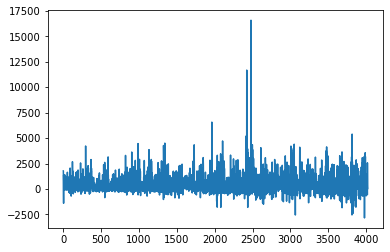

In [119]:
plt.plot(run_electricity_strategy(df=Y_r, eff=1, capacity=10,charge_level=10, ramp_rate=10, min_charge_level=0).iloc[:,4:5].values)

In [ ]:
def run_electricity_strategy(df, eff, capacity, ramp_rate, min_charge_level):
    prices = []
    charge_level = 1    
    level_0_values = df['level_0'].unique()

    for level_0 in level_0_values:
        current_df = df[df['level_0'] == level_0]
        max_price_index = current_df['Price'].idxmax()
        min_price_index = current_df['Price'].idxmin()

        smaller_index = min(min_price_index, max_price_index)
        larger_index = max(min_price_index, max_price_index)
        
        remaining_prices_0 = current_df[(current_df.index > smaller_index) & (current_df.index < larger_index)]
        remaining_prices_1 = current_df[(current_df.index > smaller_index) & (current_df.index > larger_index)]
        remaining_prices_2 = current_df[(current_df.index < smaller_index) & (current_df.index < larger_index)]

        if current_df.loc[min_price_index, 'Price'] < current_df.loc[max_price_index, 'Price'] * eff:
            if min_price_index < max_price_index:
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
            
                profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index, 'Price'] * bottleneck_1)
            
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'], max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
            elif min_price_index > max_price_index:
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
            
                profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index, 'Price'] * bottleneck_1)
            
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'],  max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
            else:
                continue
                                    
      
    
        if len(remaining_prices_0) > 1:
            max_price_index_1 = remaining_prices_0['Price'].idxmax()
            min_price_index_1 = remaining_prices_0['Price'].idxmin()
            if current_df.loc[min_price_index_1, 'Price'] < current_df.loc[max_price_index_1, 'Price'] * eff:
                  if min_price_index_1 < max_price_index_1:
                    bottleneck_1 = min(capacity - charge_level, ramp_rate)
                    charge_level += bottleneck_1
                    bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                    charge_level -= bottleneck_2
            
                    profit = (current_df.loc[max_price_index_1, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)
            
                    prices.append((min_price_index_1, current_df.loc[min_price_index_1, 'Price'], max_price_index_1, current_df.loc[max_price_index_1, 'Price'], profit, charge_level))
            
                  elif min_price_index_1 > max_price_index_1:
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
            
                        profit = (current_df.loc[max_price_index_1, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)
            
                        prices.append((min_price_index_1, current_df.loc[min_price_index_1, 'Price'], max_price_index_1, current_df.loc[max_price_index_1, 'Price'], profit, charge_level))
            
                  else:
                        continue  
       

    return pd.DataFrame(prices, columns=['minPriceIndex', 'minPrice','maxPriceIndex', 'maxPrice', 'profit', 'charge Level'])


run_electricity_strategy(df=Y_r, eff=1, capacity=5, ramp_rate=2, min_charge_level=1)

In [ ]:
def run_electricity_strategy(df, eff, capacity, ramp_rate, min_charge_level):
    prices = []
    charge_level = 5
    
    level_0_values = df['level_0'].unique()

    for level_0 in level_0_values:
        current_df = df[df['level_0'] == level_0]
        max_price_index = current_df['Price'].idxmax()
        min_price_index = current_df['Price'].idxmin()

        smaller_index = min(min_price_index, max_price_index)
        larger_index = max(min_price_index, max_price_index)
        
        if min_price_index < max_price_index:
            bottleneck_1 = min(capacity - charge_level, ramp_rate)
            bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
            charge_level += bottleneck_1
            charge_level -= bottleneck_2
            
            profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index, 'Price'] * bottleneck_1)
            
            prices.append((min_price_index, current_df.loc[min_price_index, 'Price'], 
                           max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
        elif min_price_index > max_price_index:
            bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
            charge_level -= bottleneck_2
            bottleneck_1 = min(capacity - charge_level, ramp_rate)
            charge_level += bottleneck_1
            
            profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index, 'Price'] * bottleneck_1)
            
            prices.append((min_price_index, current_df.loc[min_price_index, 'Price'], 
                           max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
        else:
            continue

    return prices
run_electricity_strategy(df=Y_r, eff=1, capacity=5, ramp_rate=2, min_charge_level=1)

In [54]:
def run_electricity_strategy(df, eff, capacity, ramp_rate, min_charge_level):
    prices = []
    charge_level = 5

    level_0_values = df['level_0'].unique()

    for level_0 in level_0_values:
        current_df = df[df['level_0'] == level_0]
        max_price_index = current_df['Price'].idxmax()
        min_price_index = current_df['Price'].idxmin()

        smaller_index = min(min_price_index, max_price_index)
        larger_index = max(min_price_index, max_price_index)
        remaining_prices_0 = current_df[(current_df.index > smaller_index) & (current_df.index < larger_index)]

        if len(remaining_prices_0) > 1:
            if min_price_index < max_price_index:
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
                max_price = current_df.loc[max_price_index, 'Price']
                min_price = current_df.loc[min_price_index, 'Price']
                profit = (max_price * bottleneck_2 * eff) - (min_price * bottleneck_1)
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'], max_price_index, max_price, bottleneck_1, bottleneck_2, profit, charge_level))
                
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
                max_price_1 = remaining_prices_0['Price'].max()
                min_price_1 = remaining_prices_0['Price'].min()
                profit_1 = (max_price_1 * bottleneck_2 * eff) - (min_price_1 * bottleneck_1)
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'], remaining_prices_0['Price'].idxmax(), max_price_1, bottleneck_1, bottleneck_2, profit_1, charge_level))
                
            else:
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
                max_price_1 = remaining_prices_0['Price'].max()
                min_price_1 = remaining_prices_0['Price'].min()
                profit_1 = (max_price_1 * bottleneck_2 * eff) - (min_price_1 * bottleneck_1)
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'], max_price_index, current_df.loc[max_price_index, 'Price'], bottleneck_1, bottleneck_2, profit_1, charge_level))
                
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
                max_price = current_df.loc[max_price_index, 'Price']
                min_price = current_df.loc[min_price_index, 'Price']
                profit = (max_price * bottleneck_2 * eff) - (min_price * bottleneck_1)
                prices.append((remaining_prices_0['Price'].idxmin(), remaining_prices_0['Price'].min(), max_price_index, current_df.loc[max_price


run_electricity_strategy(df=Y_r, eff=1, capacity=5, ramp_rate=2, min_charge_level=1)

SyntaxError: invalid syntax (3525524866.py, line 56)

In [ ]:

profitSpecific(maxHourIndex)=(price(maxHourIndex)*eff-price(minHourIndex)); 
profitSpecific(minHourIndex)=-profitSpecific(maxHourIndex)

if price(maxHourIndex)*eff> price(minHourIndex)
    if minHourIndex<maxHourIndex 
        storageFree=capacity-max(chargeLevel(minHourIndex:maxHourIndex));
        bottleneck=min([TAvail(maxHourIndex),PAvail(minHourIndex),storageFree/periodT]); 
            
    else if minHourIndex>maxHourIndex 
        storageLeft=min(chargeLevel(maxHourIndex:minHourIndex));
        bottleneck=min([TAvail(maxHourIndex),PAvail(minHourIndex),storageLeft/periodT]); 
    end
        
        
TAvail(maxHourIndex)=TAvail(maxHourIndex)-bottleneck;   
PAvail(minHourIndex)=PAvail(minHourIndex)-bottleneck;   
Tuse(maxHourIndex)=Tuse(maxHourIndex)+bottleneck;       
Puse(minHourIndex)=Puse(minHourIndex)+bottleneck;      
        
chargeLevel(maxHourIndex+1:end)=chargeLevel(maxHourIndex+1:end)-bottleneck*periodT;
chargeLevel(minHourIndex+1:end)=chargeLevel(minHourIndex+1:end)+bottleneck*periodT;

profit(maxHourIndex)=Tuse(maxHourIndex)*periodT*profitSpecific(maxHourIndex);  
profit(minHourIndex)=-profit(maxHourIndex);

profitTotal=profitTotal+profit(maxHourIndex);


In [62]:
def run_electricity_strategy(df, eff, capacity, ramp_rate, min_charge_level):
    prices = []
    charge_level = 5    
    level_0_values = df['level_0'].unique()

    for level_0 in level_0_values:
        current_df = df[df['level_0'] == level_0]
        max_price_index = current_df['Price'].idxmax()
        min_price_index = current_df['Price'].idxmin()

        smaller_index = min(min_price_index, max_price_index)
        larger_index = max(min_price_index, max_price_index)
        
        remaining_prices_0 = current_df[(current_df.index > smaller_index) & (current_df.index < larger_index)]
        remaining_prices_1 = current_df[(current_df.index > smaller_index) & (current_df.index > larger_index)]
        remaining_prices_2 = current_df[(current_df.index < smaller_index) & (current_df.index < larger_index)]

        if current_df.loc[min_price_index, 'Price'] < current_df.loc[max_price_index, 'Price'] * eff:
            if min_price_index < max_price_index:
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
            
                profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index, 'Price'] * bottleneck_1)
            
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'], max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
            elif min_price_index > max_price_index:
                bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                charge_level -= bottleneck_2
                bottleneck_1 = min(capacity - charge_level, ramp_rate)
                charge_level += bottleneck_1
            
                profit = (current_df.loc[max_price_index, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index, 'Price'] * bottleneck_1)
            
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'],  max_price_index, current_df.loc[max_price_index, 'Price'], profit, charge_level))
            
            else:
                continue
            
            
            
            
           
            
            
            
            
            
      
    
        if len(remaining_prices_0) > 1:
            max_price_index_1 = remaining_prices_0['Price'].idxmax()
            min_price_index_1 = remaining_prices_0['Price'].idxmin()
            if current_df.loc[min_price_index_1, 'Price'] < current_df.loc[max_price_index_1, 'Price'] * eff:
                  if min_price_index_1 < max_price_index_1:
                    bottleneck_1 = min(capacity - charge_level, ramp_rate)
                    charge_level += bottleneck_1
                    bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                    charge_level -= bottleneck_2
            
                    profit = (current_df.loc[max_price_index_1, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)
            
                    prices.append((min_price_index_1, current_df.loc[min_price_index_1, 'Price'], max_price_index_1, current_df.loc[max_price_index_1, 'Price'], profit, charge_level))
            
                  elif min_price_index_1 > max_price_index_1:
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
            
                        profit = (current_df.loc[max_price_index_1, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)
            
                        prices.append((min_price_index_1, current_df.loc[min_price_index_1, 'Price'], max_price_index_1, current_df.loc[max_price_index_1, 'Price'], profit, charge_level))
            
                  else:
                        continue
                    
                    
                    
 
                    
            smaller_index_1 = min(min_price_index_1, max_price_index_1)
            larger_index_1 = max(min_price_index_1, max_price_index_1)
            remaining_prices_01 = current_df[(current_df.index > smaller_index_1) & (current_df.index < larger_index_1)]
            if len(remaining_prices_01) > 1:
                max_price_index_4 = remaining_prices_01['Price'].idxmax()
                min_price_index_4 = remaining_prices_01['Price'].idxmin()
                if current_df.loc[min_price_index_4, 'Price'] < current_df.loc[max_price_index_4, 'Price'] * eff:
                    if min_price_index_4 < max_price_index_4:
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                    
                        profit = (current_df.loc[max_price_index_4, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_4, 'Price'] * bottleneck_1)
                    
                        prices.append((min_price_index_4, current_df.loc[min_price_index_4, 'Price'], max_price_index_1, current_df.loc[max_price_index_4, 'Price'], profit, charge_level))
                    
                    elif min_price_index_4 > max_price_index_4:
                          bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                          charge_level -= bottleneck_2
                          bottleneck_1 = min(capacity - charge_level, ramp_rate)
                          charge_level += bottleneck_1
                    
                          profit = (current_df.loc[max_price_index_4, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_1, 'Price'] * bottleneck_1)
                    
                          prices.append((min_price_index_4, current_df.loc[min_price_index_4, 'Price'], max_price_index_4, current_df.loc[max_price_index_4, 'Price'], profit, charge_level))
                                
                    else:
                         continue

                    
                    
        if len(remaining_prices_1) > 1:
            max_price_index_2 = remaining_prices_1['Price'].idxmax()
            min_price_index_2 = remaining_prices_1['Price'].idxmin()
            if current_df.loc[min_price_index_2, 'Price'] < current_df.loc[max_price_index_2, 'Price'] * eff:
                  if min_price_index_2 < max_price_index_2:
                    bottleneck_1 = min(capacity - charge_level, ramp_rate)
                    charge_level += bottleneck_1
                    bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                    charge_level -= bottleneck_2
            
                    profit = (current_df.loc[max_price_index_2, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_2, 'Price'] * bottleneck_1)
            
                    prices.append((min_price_index_2, current_df.loc[min_price_index_2, 'Price'], max_price_index_2, current_df.loc[max_price_index_2, 'Price'], profit, charge_level))
            
                  elif min_price_index_2 > max_price_index_2:
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
            
                        profit = (current_df.loc[max_price_index_2, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_2, 'Price'] * bottleneck_1)
            
                        prices.append((min_price_index_2, current_df.loc[min_price_index_2, 'Price'], max_price_index_2, current_df.loc[max_price_index_2, 'Price'], profit, charge_level))
            
                  else:
                        continue
                    

                    
                    
        if len(remaining_prices_2) > 1:
            max_price_index_3 = remaining_prices_2['Price'].idxmax()
            min_price_index_3 = remaining_prices_2['Price'].idxmin()
            if current_df.loc[min_price_index_3, 'Price'] < current_df.loc[max_price_index_3, 'Price'] * eff:
                  if min_price_index_3 < max_price_index_3:
                    bottleneck_1 = min(capacity - charge_level, ramp_rate)
                    charge_level += bottleneck_1
                    bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                    charge_level -= bottleneck_2
            
                    profit = (current_df.loc[max_price_index_3, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_3, 'Price'] * bottleneck_1)
            
                    prices.append((min_price_index_3, current_df.loc[min_price_index_3, 'Price'], max_price_index_3, current_df.loc[max_price_index_3, 'Price'], profit, charge_level))
            
                  elif min_price_index_3 > max_price_index_3:
                        bottleneck_2 = min(charge_level - min_charge_level, ramp_rate)
                        charge_level -= bottleneck_2
                        bottleneck_1 = min(capacity - charge_level, ramp_rate)
                        charge_level += bottleneck_1
            
                        profit = (current_df.loc[max_price_index_3, 'Price'] * bottleneck_2 * eff) - (current_df.loc[min_price_index_3, 'Price'] * bottleneck_1)
            
                        prices.append((min_price_index_3, current_df.loc[min_price_index_3, 'Price'], max_price_index_3, current_df.loc[max_price_index_3, 'Price'], profit, charge_level))
            
                  else:
                        continue         
                        
    
    

    return prices
run_electricity_strategy(df=Y_r, eff=1, capacity=5, ramp_rate=2, min_charge_level=1)

[(4, 11.58, 16, 31.66, 63.32, 3),
 (5, 12.26, 9, 25.83, 27.139999999999997, 3),
 (6, 15.34, 9, 23.22, 15.759999999999998, 3),
 (23, 13.98, 17, 31.66, 35.36, 3),
 (3, 14.12, 0, 24.65, 21.06, 3)]

In [59]:
def run_electricity_strategy(df, eff):
    prices = []
    level_0_values = df['level_0'].unique()

    for level_0 in level_0_values:
        current_df = df[df['level_0'] == level_0]
        max_price_index = current_df['Price'].idxmax()
        min_price_index = current_df['Price'].idxmin()

        smaller_index = min(min_price_index, max_price_index)
        larger_index = max(min_price_index, max_price_index)
        remaining_prices_0 = current_df[(current_df.index > smaller_index) & (current_df.index < larger_index)]
        remaining_prices_1 = current_df[(current_df.index > smaller_index) & (current_df.index > larger_index)]
        remaining_prices_2 = current_df[(current_df.index < smaller_index) & (current_df.index < larger_index)]

        if len(remaining_prices_0) > 1:
            max_price_index_1 = remaining_prices_0['Price'].idxmax()
            min_price_index_1 = remaining_prices_0['Price'].idxmin()
            if current_df.loc[min_price_index_1, 'Price'] < current_df.loc[max_price_index, 'Price'] * eff:
                prices.append((min_price_index, current_df.loc[min_price_index, 'Price'], 
                               max_price_index, current_df.loc[max_price_index, 'Price']))

                prices.append((min_price_index_1, current_df.loc[min_price_index_1, 'Price'], 
                               max_price_index_1, current_df.loc[max_price_index_1, 'Price']))

                smaller_index_1 = min(min_price_index_1, max_price_index_1)
                larger_index_1 = max(min_price_index_1, max_price_index_1)
                remaining_prices_01 = current_df[(current_df.index > smaller_index_1) & (current_df.index < larger_index_1)]
                if len(remaining_prices_01) > 1:
                    max_price_index_4 = remaining_prices_01['Price'].idxmax()
                    min_price_index_4 = remaining_prices_01['Price'].idxmin()
                    if current_df.loc[min_price_index_4, 'Price'] < current_df.loc[max_price_index_1, 'Price'] * eff:
                        prices.append((min_price_index_4, current_df.loc[min_price_index_4, 'Price'], 
                                       max_price_index_4, current_df.loc[max_price_index_4, 'Price']))           
        if len(remaining_prices_1) > 1:
            max_price_index_2 = remaining_prices_1['Price'].idxmax()
            min_price_index_2 = remaining_prices_1['Price'].idxmin()
            if current_df.loc[min_price_index_2, 'Price'] < current_df.loc[max_price_index_1, 'Price'] * eff:
                prices.append((min_price_index_2, current_df.loc[min_price_index_2, 'Price'], 
                               max_price_index_2, current_df.loc[max_price_index_2, 'Price']))

        if len(remaining_prices_2) > 1:
            max_price_index_3 = remaining_prices_2['Price'].idxmax()
            min_price_index_3 = remaining_prices_2['Price'].idxmin()
            if current_df.loc[min_price_index_3, 'Price'] < current_df.loc[max_price_index_3, 'Price'] * eff:
                prices.append((min_price_index_3, current_df.loc[min_price_index_3, 'Price'], 
                               max_price_index_3, current_df.loc[max_price_index_3, 'Price']))

                               
    return prices

run_electricity_strategy(df=Y_r, eff=1)

TypeError: run_electricity_strategy() missing 3 required positional arguments: 'capacity', 'ramp_rate', and 'min_charge_level'